In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

"Machine learning tools"
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
import pickle

#from src.classification.datasets import Dataset
from src.classification.utils.plots import plot_specgram, show_confusion_matrix, plot_decision_boundaries
from src.classification.utils.utils import accuracy
#from src.classification.utils.audio_student import AudioUtil, Feature_vector_DS

In [2]:
np.random.seed(0)

In [3]:
fm_dir = "data/feature_matrices/" # where to save the features matrices
model_dir = "data/models/" # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

<font size=5 color=#009999> 1. Creation of the feature vectors matrix and dataset splitting </font> <br>


In [24]:
def create_FV_matrix(nb_FV=700): # number of FV, being the same for each class 
    start = time.time()
    classnames = ["birds", "chainsaw","fire","handsaw","helicopter"]
    labels = np.repeat(classnames, nb_FV)
    
    FV_matrix = np.zeros((nb_FV*len(classnames), 400))
    
    for i in range(nb_FV):
        fvi = np.load("src/classification/datasets/FV_birds/FV_bird"+str(i+1)+".npy")
        FV_matrix[i] = fvi
    print("birds loaded")
    
    for i in range(nb_FV):
        fvi = np.load("src/classification/datasets/FV_chainsaws/FV_chainsaw"+str(i+1)+".npy")
        FV_matrix[nb_FV + i] = fvi
    print("chainsaw loaded")
    
    for i in range(nb_FV):
        fvi = np.load("src/classification/datasets/FV_fires/FV_fire"+str(i+1)+".npy")
        FV_matrix[2*nb_FV + i] = fvi
    print("fire loaded")

    for i in range(nb_FV):
        fvi = np.load("src/classification/datasets/FV_handsaws/FV_handsaw"+str(i+1)+".npy")
        FV_matrix[3*nb_FV + i] = fvi
    print("handsaw loaded")

    for i in range(nb_FV):
        fvi = np.load("src/classification/datasets/FV_helicopters/FV_helicopter"+str(i+1)+".npy")
        FV_matrix[4*nb_FV + i] = fvi
    print("helicopter loaded")
 
    np.save(fm_dir+"Our_FV_matrix_2D___V3.npy", FV_matrix) # save the matrix to not load this cell again
    np.save(fm_dir+"Labels_matrix___V3.npy", labels)

    print("---------------------------------")
    print("nb_FV * nb_classes =", nb_FV * len(classnames))
    print(FV_matrix.shape)
    print(labels.shape)
    end = time.time()
    print("Temps d'exécution:",np.round(end-start,3),"[s]")

#create_FV_matrix()

birds loaded
chainsaw loaded
fire loaded
handsaw loaded
helicopter loaded
---------------------------------
nb_FV * nb_classes = 3500
(3500, 400)
(3500,)
Temps d'exécution: 11.326 [s]


In [4]:
classnames = ["birds", "chainsaw","fire","handsaw","helicopter"]
FV_matrix = np.load(fm_dir+"Our_FV_matrix_2D___V3.npy")
labels = np.load(fm_dir+"Labels_matrix___V3.npy")

In [5]:
# Shuffle then split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(FV_matrix, labels, test_size=0.3, stratify=labels) # random_state=1

print('Shape of the training matrix : {}'.format(X_train.shape))
print('Number of training labels : {}'.format(len(y_train)))

Shape of the training matrix : (2450, 400)
Number of training labels : 2450


<font size=5 color=#009999> 2. Creation of models and training</font> <br>
Training with K-fold cross validation (to avoid overfitting) and normalisation

`TO STUDY :`
- Hyper parameters of the model
- Impact on the accuracy of number of folds chosen
- What happens with this normalisation countermeasure when there is no sound around the microphone? Is this desirable? How could we deal with it?

In [6]:
model_svm = svm.SVC(kernel="linear",gamma="scale",C=1)

model_rft = RandomForestClassifier(n_estimators=100, criterion="log_loss",min_samples_split=2,min_samples_leaf=1)

Split 1 / 7
Split 2 / 7
Split 3 / 7
Split 4 / 7
Split 5 / 7
Split 6 / 7
Split 7 / 7
-----------------------------------------------
Mean accuracy of SVM with 5-Fold CV: 55.9%
Std deviation in accuracy of SVM with 5-Fold CV: 1.8%
Accuracy of SVM on test set : 55.9%


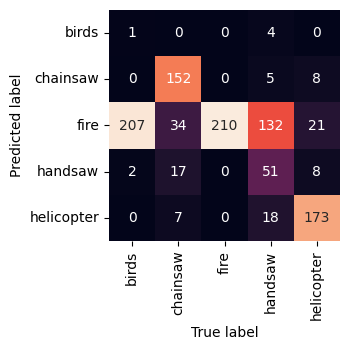


Mean accuracy of RFT with 5-Fold CV: 71.6%
Std deviation in accuracy of RFT with 5-Fold CV: 1.7%
Accuracy of RFT on test set : 71.6%


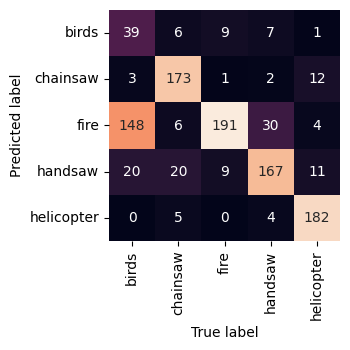

Temps d'exécution: 8.862 [s]


In [8]:
def training(n_splits=5, normalize=True):

    start = time.time()
    kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
    accuracyCV_svm = np.zeros((n_splits,))
    accuracyCV_rft = np.zeros((n_splits,))
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
        print("Split",k+1,"/",n_splits)
        (idx_learn, idx_val) = idx

        if normalize == True :
            X_learn_normalised = X_train[idx_learn]/ np.linalg.norm(X_train[idx_learn], axis=1, keepdims=True)
            X_val_normalised = X_train[idx_val]/ np.linalg.norm(X_train[idx_val], axis=1, keepdims=True)
        else :
            X_learn_normalised = X_train[idx_learn]
            X_val_normalised = X_train[idx_val]
            
        model_svm.fit(X_learn_normalised, y_train[idx_learn])
        prediction_svm = model_svm.predict(X_val_normalised)
        accuracyCV_svm[k] = accuracy(prediction_svm, y_train[idx_val])

        model_rft.fit(X_learn_normalised, y_train[idx_learn])
        prediction_rft = model_rft.predict(X_val_normalised)
        accuracyCV_rft[k] = accuracy(prediction_rft, y_train[idx_val])

    
    if normalize == True :
        X_test_normalised = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)
    else :
        X_test_normalised = X_test
        
    prediction_svm = model_svm.predict(X_test_normalised)
    prediction_rft = model_rft.predict(X_test_normalised)
    accuracy_svm = accuracy (prediction_svm, y_test)
    accuracy_rft = accuracy (prediction_rft, y_test)

    print("-----------------------------------------------")
    print('Mean accuracy of SVM with 5-Fold CV: {:.1f}%'.format(100*accuracy_svm.mean()))
    print('Std deviation in accuracy of SVM with 5-Fold CV: {:.1f}%'.format(100*accuracyCV_svm.std()))
    print('Accuracy of SVM on test set : {:.1f}%'.format(100*accuracy_svm))
    show_confusion_matrix (prediction_svm, y_test, classnames)
    print()
    print('Mean accuracy of RFT with 5-Fold CV: {:.1f}%'.format(100*accuracy_rft.mean()))
    print('Std deviation in accuracy of RFT with 5-Fold CV: {:.1f}%'.format(100*accuracyCV_rft.std()))
    print('Accuracy of RFT on test set : {:.1f}%'.format(100*accuracy_rft))
    show_confusion_matrix (prediction_rft, y_test, classnames)

    end = time.time()
    print("Temps d'exécution:",np.round(end-start,3),"[s]")

training(n_splits=7, normalize=True)

<font size=5 color=#009999> 3.1 Study of hyperparameters : SVM</font> <br>

n_splits =  2
n_splits =  3
n_splits =  4
n_splits =  5
n_splits =  6
n_splits =  7
n_splits =  8
n_splits =  9
n_splits =  10
n_splits =  11
n_splits =  12
n_splits =  13
n_splits =  14
n_splits =  15
n_splits =  16
n_splits =  17
n_splits =  18
n_splits =  19
n_splits =  20
n_splits =  21
n_splits =  22
n_splits =  23
n_splits =  24
n_splits =  25
n_splits =  26
n_splits =  27
n_splits =  28
n_splits =  29
n_splits =  30
n_splits =  31
n_splits =  32
n_splits =  33
n_splits =  34
n_splits =  35
n_splits =  36
n_splits =  37
n_splits =  38
n_splits =  39
n_splits =  40
n_splits =  41
n_splits =  42
n_splits =  43
n_splits =  44
n_splits =  45
n_splits =  46
n_splits =  47
n_splits =  48
n_splits =  49


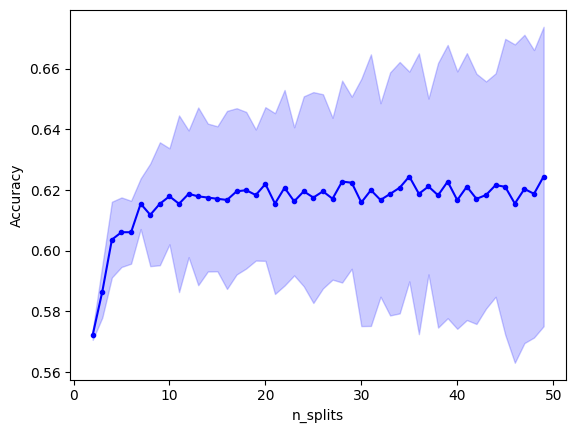

means svm :
[0.5722449  0.58652581 0.60367887 0.60612245 0.60611826 0.6155102
 0.61184694 0.61549684 0.61795918 0.61549748 0.61877292 0.61794352
 0.61755102 0.61714051 0.6167611  0.61959657 0.61996982 0.61837324
 0.62201786 0.61556356 0.620788   0.61629726 0.61960229 0.61755102
 0.61959686 0.61716637 0.6228215  0.62243794 0.61593396 0.61999285
 0.61674962 0.6187442  0.62080312 0.6244898  0.61879559 0.6211999
 0.61830086 0.62280909 0.61671074 0.62115888 0.61712031 0.61839191
 0.6216647  0.62108492 0.61556224 0.62038724 0.61878614 0.6244898 ]
stds svm :
[0.00163265 0.00855992 0.01248812 0.01147222 0.01037617 0.00834492
 0.01691741 0.02026783 0.01582916 0.02912701 0.02090149 0.0293
 0.02438413 0.02390951 0.02935159 0.02741369 0.02581308 0.02161067
 0.02533279 0.02980752 0.032244   0.02442528 0.03131815 0.03476823
 0.03201151 0.02668651 0.03328781 0.02837748 0.04077018 0.04477341
 0.03190023 0.04007078 0.04145312 0.03458567 0.04629732 0.02898411
 0.04363714 0.04505561 0.04243818 0.0440075 

In [30]:
############# SVM ###############
#----- nb splits in K-Fold -----#

n_splits = np.arange(2,50,1)
accuracies_svm = [] #np.zeros((len(n_splits), len(n_splits)))

for i,nsplt in enumerate(n_splits):
    print("n_splits = ",nsplt)
    model_svm = svm.SVC()
    kf = StratifiedKFold(n_splits=nsplt,shuffle=True)
    acc_i = []
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
        
            model_svm.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_svm = model_svm.predict(X_train[idx_val])
            acc_i.append(accuracy(prediction_svm, y_train[idx_val]))
    accuracies_svm.append(acc_i)
        
means_svm = np.zeros(len(n_splits))
stds_svm = np.zeros(len(n_splits))
for i in range(len(n_splits)):
    means_svm[i] = np.array(accuracies_svm[i]).mean()
    stds_svm[i] = np.array(accuracies_svm[i]).std()


plt.figure()
plt.plot(n_splits,means_svm,'.-b')
plt.fill_between(n_splits,means_svm-stds_svm,means_svm+stds_svm,alpha=0.2,color='b')
plt.xlabel('n_splits')
plt.ylabel('Accuracy')
#plt.ylim([0.8,1])
#plt.legend()
plt.show()
print("means svm :")
print(means_svm)
print("stds svm :")
print(stds_svm)

/tmp/ipykernel_940/2342362806.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["","linear","", "poly","", "rbf", "","sigmoid"])


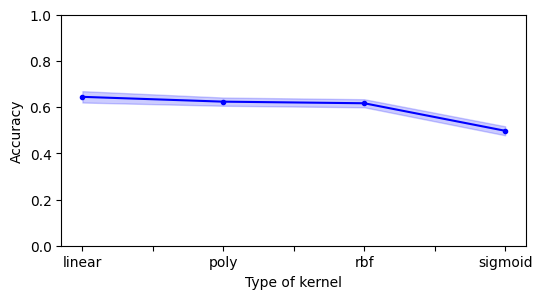

[0.6444898  0.62367347 0.61673469 0.49755102]


In [39]:
########## SVM #############
#----- Type of kernel -----#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
kernels = ["linear", "poly", "rbf", "sigmoid"]
accuracies_svm = np.zeros((len(kernels), n_splits))

for i,K in enumerate(kernels):
    model_svm = svm.SVC(kernel=K) 
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_svm.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_svm = model_svm.predict(X_train[idx_val])
            accuracies_svm[i,k] = accuracy(prediction_svm, y_train[idx_val])
        
means_svm = accuracies_svm.mean(axis=1)
stds_svm = accuracies_svm.std(axis=1)


fig, ax = plt.subplots(figsize=(6,3))
ax.plot(np.arange(0,len(kernels),1), means_svm, '.-b')
ax.fill_between(np.arange(0,len(kernels),1),means_svm-stds_svm,means_svm+stds_svm,alpha=0.2,color='b')
ax.set_xticklabels(["","linear","", "poly","", "rbf", "","sigmoid"])
plt.ylim(0,1)
ax.set_xlabel('Type of kernel')
ax.set_ylabel('Accuracy')
plt.show()
print(means_svm)

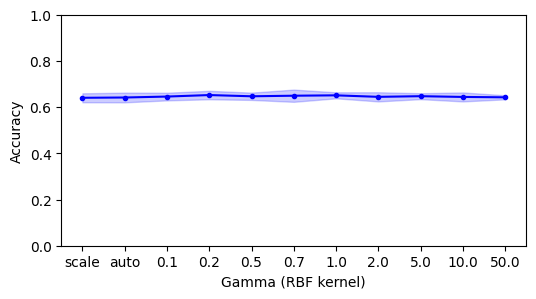

[0.64040816 0.64163265 0.64571429 0.6522449  0.64693878 0.64938776
 0.65102041 0.6444898  0.64734694 0.64408163 0.64244898]


In [41]:
########## SVM #############
#------ Gamma (RBF) -------#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
gamma = ["scale","auto", 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0, 50.0]
accuracies_svm = np.zeros((len(gamma), n_splits))

for i, g in enumerate(gamma):
    model_svm = svm.SVC(kernel="linear", gamma=g) 
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_svm.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_svm = model_svm.predict(X_train[idx_val])
            accuracies_svm[i,k] = accuracy(prediction_svm, y_train[idx_val])
        
means_svm = accuracies_svm.mean(axis=1)
stds_svm = accuracies_svm.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(np.arange(0,len(gamma),1), means_svm, '.-b')
plt.fill_between(np.arange(0,len(gamma),1),means_svm-stds_svm,means_svm+stds_svm,alpha=0.2,color='b')
plt.xticks(np.arange(0,len(gamma),1),["scale","auto", 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0, 50.0])
plt.ylim(0,1)
plt.xlabel('Gamma (RBF kernel)')
plt.ylabel('Accuracy')
plt.show()
print(means_svm)

0.5
1
2
3
4
5


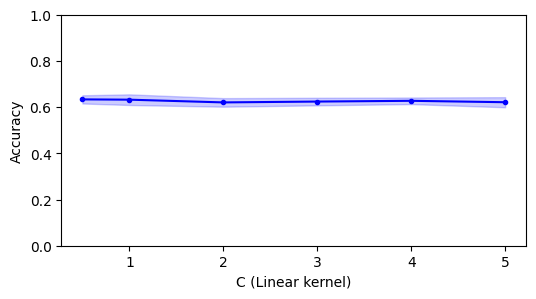

[0.63346939 0.6322449  0.62040816 0.62408163 0.62734694 0.62122449]


In [10]:
########## SVM #############
#-------- C (RBF) ---------#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
C = [0.5,1,2,3,4,5]
accuracies_svm = np.zeros((len(C), n_splits))

for i, c in enumerate(C):
    print(c)
    model_svm = svm.SVC(kernel="linear", C=c) 
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_svm.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_svm = model_svm.predict(X_train[idx_val])
            accuracies_svm[i,k] = accuracy(prediction_svm, y_train[idx_val])
        
means_svm = accuracies_svm.mean(axis=1)
stds_svm = accuracies_svm.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(C, means_svm, '.-b')
plt.fill_between(C,means_svm-stds_svm,means_svm+stds_svm,alpha=0.2,color='b')
#plt.xticks(np.arange(0,len(gamma),1),["scale","auto", 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0, 50.0])
plt.ylim(0,1)
plt.xlabel('C (Linear kernel)')
plt.ylabel('Accuracy')
plt.show()
print(means_svm)

In [ ]:
############ SVM ###############
#------ LinearSVC tuning ------#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
loss = ["hinge", "squared_hinge"]
accuracies_lin = np.zeros((len(loss), n_splits))

for i, l in enumerate(loss):
    model_lin = svm.LinearSVC(dual="auto", max_iter=1000000, loss=l) 
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_lin.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_lin = model_lin.predict(X_train[idx_val])
            accuracies_lin[i,k] = accuracy(prediction_lin, y_train[idx_val])
        
means_lin = accuracies_lin.mean(axis=1)
stds_lin = accuracies_lin.std(axis=1)

plt.figure(figsize=(6,3))
plt.plot(np.arange(0,len(loss),1), means_lin, '.-b')
plt.fill_between(np.arange(0,len(loss),1),means_lin-stds_lin,means_lin+stds_lin,alpha=0.2,color='b')
plt.xticks(np.arange(0,len(loss),1),loss)
plt.ylim(0,1)
plt.xlabel('Linear SVC : Loss function')
plt.ylabel('Accuracy')
plt.show()
print(means_lin)


C = [0.5,1,5,10]
accuracies_lin = np.zeros((len(C), n_splits))

for i, c in enumerate(C):
    model_lin = svm.LinearSVC(dual="auto", max_iter=1000000, C=c) 
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_lin.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_lin = model_lin.predict(X_train[idx_val])
            accuracies_lin[i,k] = accuracy(prediction_lin, y_train[idx_val])
        
means_lin = accuracies_lin.mean(axis=1)
stds_lin = accuracies_lin.std(axis=1)

plt.figure(figsize=(6,3))
plt.plot(C, means_lin, '.-b')
plt.fill_between(C,means_lin-stds_lin,means_lin+stds_lin,alpha=0.2,color='b')
plt.ylim(0,1)
plt.xlabel('Linear SVC : C')
plt.ylabel('Accuracy')
plt.show()
print(means_lin)

/home/auvermeulen/.cache/pypoetry/virtualenvs/lelec210x-dp0PniS1-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/auvermeulen/.cache/pypoetry/virtualenvs/lelec210x-dp0PniS1-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [6]:
############ SVM ###############
#------ SVC vs LinearSVC ------#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
accuracies_SVC = np.zeros(n_splits)
accuracies_LinearSVC = np.zeros(n_splits)


model_SVC = svm.SVC(kernel="linear") 
model_LinearSVC = svm.LinearSVC(dual="auto", max_iter=100000)

for k, idx in enumerate(kf.split(X_train,y_train)):
        (idx_learn, idx_val) = idx
        model_SVC.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_SVC = model_SVC.predict(X_train[idx_val])
        accuracies_SVC[k] = accuracy(prediction_SVC, y_train[idx_val])

        model_LinearSVC.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_LinearSVC = model_LinearSVC.predict(X_train[idx_val])
        accuracies_LinearSVC[k] = accuracy(prediction_LinearSVC, y_train[idx_val])
        
means_SVC = accuracies_SVC.mean()
stds_SVC = accuracies_SVC.std()
means_LinearSVC = accuracies_LinearSVC.mean()
stds_LinearSVC = accuracies_LinearSVC.std()

print('Mean accuracy of SVC with 5-Fold CV: {:.1f}%'.format(100*means_SVC))
print('Std deviation in accuracy of SVM with 5-Fold CV: {:.1f}%'.format(100*stds_SVC))
print()
print('Mean accuracy of LinearSVC with 5-Fold CV: {:.1f}%'.format(100*means_LinearSVC))
print('Std deviation in accuracy of LinearSVC with 5-Fold CV: {:.1f}%'.format(100*stds_LinearSVC))
print()

Mean accuracy of SVC with 5-Fold CV: 62.8%
Std deviation in accuracy of SVM with 5-Fold CV: 1.6%

Mean accuracy of LinearSVC with 5-Fold CV: 64.4%
Std deviation in accuracy of LinearSVC with 5-Fold CV: 2.5%



<font size=5 color=#009999> 3.2 Study of hyperparameters : Random Forest</font> <br>

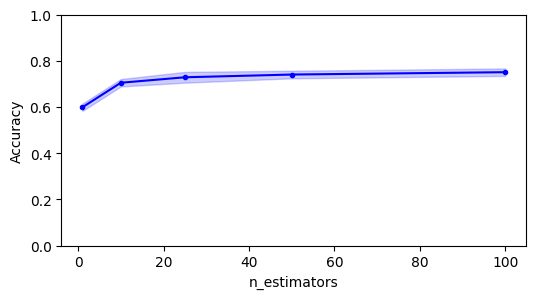

[0.59877551 0.70489796 0.72857143 0.74040816 0.75061224]


In [8]:
########## RFT #############
#------ n_estimators ------#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
n_estimators = [1,10,25,50,100]
accuracies_rft = np.zeros((len(n_estimators), n_splits))

for i, n in enumerate(n_estimators):
    model_rft = RandomForestClassifier(n_estimators=n)
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_rft.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_rft = model_rft.predict(X_train[idx_val])
            accuracies_rft[i,k] = accuracy(prediction_rft, y_train[idx_val])
        
means_rft = accuracies_rft.mean(axis=1)
stds_rft = accuracies_rft.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(n_estimators, means_rft, '.-b')
plt.fill_between(n_estimators,means_rft-stds_rft,means_rft+stds_rft,alpha=0.2,color='b')
#plt.xticks(np.arange(0,len(gamma),1),["scale","auto", 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0, 50.0])
plt.ylim(0,1)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()
print(means_rft)

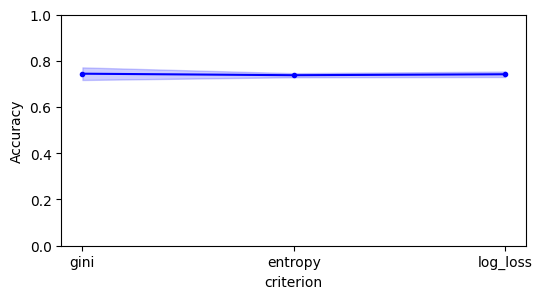

[0.74408163 0.73755102 0.74163265]


In [9]:
########## RFT #############
#------- criterion --------#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
criterion =["gini","entropy","log_loss"]
accuracies_rft = np.zeros((len(criterion), n_splits))

for i, c in enumerate(criterion):
    model_rft = RandomForestClassifier(criterion=c)
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_rft.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_rft = model_rft.predict(X_train[idx_val])
            accuracies_rft[i,k] = accuracy(prediction_rft, y_train[idx_val])
        
means_rft = accuracies_rft.mean(axis=1)
stds_rft = accuracies_rft.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(np.arange(0,len(criterion),1), means_rft, '.-b')
plt.fill_between(np.arange(0,len(criterion),1),means_rft-stds_rft,means_rft+stds_rft,alpha=0.2,color='b')
plt.xticks(np.arange(0,len(criterion),1),criterion)
plt.ylim(0,1)
plt.xlabel('criterion')
plt.ylabel('Accuracy')
plt.show()
print(means_rft)

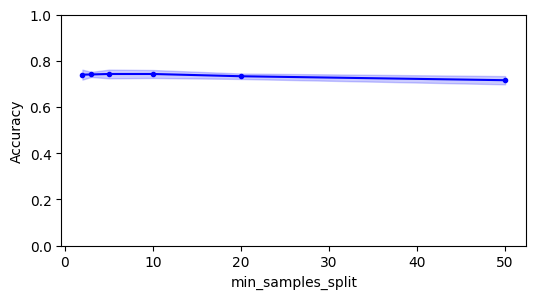

[0.74       0.74081633 0.74285714 0.74285714 0.73306122 0.71591837]


In [10]:
########## RFT #############
#---- min_samples_split ---#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
min = [2,3,5,10,20,50]
accuracies_rft = np.zeros((len(min), n_splits))

for i, n in enumerate(min):
    model_rft = RandomForestClassifier(min_samples_split=n)
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_rft.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_rft = model_rft.predict(X_train[idx_val])
            accuracies_rft[i,k] = accuracy(prediction_rft, y_train[idx_val])
        
means_rft = accuracies_rft.mean(axis=1)
stds_rft = accuracies_rft.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(min, means_rft, '.-b')
plt.fill_between(min,means_rft-stds_rft,means_rft+stds_rft,alpha=0.2,color='b')
#plt.xticks(np.arange(0,len(gamma),1),["scale","auto", 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0, 50.0])
plt.ylim(0,1)
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.show()
print(means_rft)

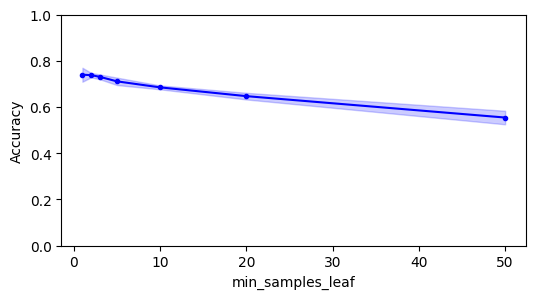

[0.73959184 0.73795918 0.73061224 0.71102041 0.68489796 0.64693878
 0.55428571]


In [11]:
########## RFT #############
#---- min_samples_leaf ----#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
min = [1,2,3,5,10,20,50]
accuracies_rft = np.zeros((len(min), n_splits))

for i, n in enumerate(min):
    model_rft = RandomForestClassifier(min_samples_leaf=n)
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_rft.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_rft = model_rft.predict(X_train[idx_val])
            accuracies_rft[i,k] = accuracy(prediction_rft, y_train[idx_val])
        
means_rft = accuracies_rft.mean(axis=1)
stds_rft = accuracies_rft.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(min, means_rft, '.-b')
plt.fill_between(min,means_rft-stds_rft,means_rft+stds_rft,alpha=0.2,color='b')
#plt.xticks(np.arange(0,len(gamma),1),["scale","auto", 0.1, 0.2, 0.5, 0.7, 1.0, 2.0, 5.0, 10.0, 50.0])
plt.ylim(0,1)
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.show()
print(means_rft)

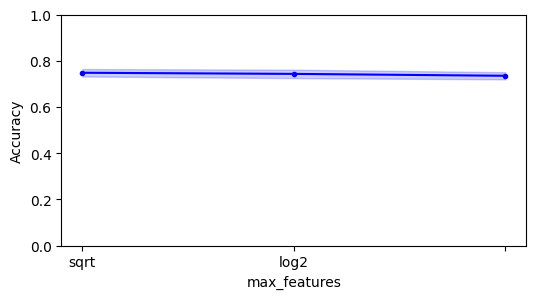

[0.74816327 0.74326531 0.73510204]


In [12]:
########## RFT #############
#---- min_samples_split ---#

n_splits = 7
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)
max_features = ["sqrt","log2", None]
accuracies_rft = np.zeros((len(max_features), n_splits))

for i, m in enumerate(max_features):
    model_rft = RandomForestClassifier(max_features=m)
    
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_rft.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_rft = model_rft.predict(X_train[idx_val])
            accuracies_rft[i,k] = accuracy(prediction_rft, y_train[idx_val])
        
means_rft = accuracies_rft.mean(axis=1)
stds_rft = accuracies_rft.std(axis=1)


plt.figure(figsize=(6,3))
plt.plot(np.arange(0,len(max_features),1), means_rft, '.-b')
plt.fill_between(np.arange(0,len(max_features),1),means_rft-stds_rft,means_rft+stds_rft,alpha=0.2,color='b')
plt.xticks(np.arange(0,len(max_features),1),max_features)
plt.ylim(0,1)
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.show()
print(means_rft)

<font size=5 color=#009999> --- Saving the models ---</font> <br>

In [9]:
filename = 'Our_RFT_V2_normalized.pickle'
pickle.dump(model_rft, open(model_dir+filename, 'wb'))